# **Credit Default Prediction Using XGBoost**
This project focuses on predicting credit default risk using machine learning and data science techniques, specifically XGBoost. We use the dataset from PPDF PPDAI Group, Inc.(In Chinese “拍拍贷”). The workflow consists of data preprocessing, feature engineering, hyperparameter tuning, model training, and feature selection.

Some clarifications
- Bad samples are users who default with 'target' = 1
- Good samples are users who do not default with 'target' = 0

In [31]:
# Load packages
import pandas as pd
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
import datetime
import collections
import numpy as np
import numbers
import random
import sys
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from importlib import reload
from matplotlib import pyplot as plt

In [32]:
# Set up functions we need

# Function to select time windows
def TimeWindowSelection(df, daysCol, time_windows):
    '''
    :param df: the dataset containg variabel of days
    :param daysCol: the column of days
    :param time_windows: the list of time window
    :return:
    '''
    freq_tw = {}
    for tw in time_windows:
        freq = sum(df[daysCol].apply(lambda x: int(x<=tw)))
        freq_tw[tw] = freq
    return freq_tw


# Function to deal with calculation when the denominator is 0
def DeivdedByZero(nominator, denominator):
    '''
    when the demonimator is 0, then return 0; otherwise, calculate as normal
    '''
    if denominator == 0:
        return 0
    else:
        return nominator*1.0/denominator


# Standardize Update Information
def ChangeContent(x):
    y = x.upper()
    if y == '_MOBILEPHONE':
        y = '_PHONE'
    return y


# Funtion to deal with missing categorical values
def MissingCategorial(df,x):
    missing_vals = df[x].map(lambda x: int(x!=x))
    return sum(missing_vals)*1.0/df.shape[0]


# Funtion to deal with missing numerical values
def MissingContinuous(df,x):
    missing_vals = df[x].map(lambda x: int(np.isnan(x)))
    return sum(missing_vals) * 1.0 / df.shape[0]


# Function to fill missing values (NaN) with a randomly selected value 
def MakeupRandom(x, sampledList):
    if x==x:
        return x
    else:
        randIndex = random.randint(0, len(sampledList)-1)
        return sampledList[randIndex]


# Function to detect outliers (25% - 1.5std, 75% + 1.5std)
def Outlier_Dectection(df,x):
    '''
    :param df:
    :param x:
    :return:
    '''
    p25, p75 = np.percentile(df[x], 25),np.percentile(df[x], 75)
    d = p75 - p25
    upper, lower =  p75 + 1.5*d, p25-1.5*d
    truncation = df[x].map(lambda x: max(min(upper, x), lower))
    return truncation

### **Stage 1. Data Preparation & Feature Engineering**

### Data Cleaning & Splitting:
Loaded three datasets containing:
- PPD_LogInfo.csv: login records of users
- PPD_Training_Master_GBK.csv: User information
- PPD_Userupdate_Info.csv: Uodapted information

Then we merged data and split into training (70%) and testing (30%) sets.

In [5]:
# Load and display the data
data1 = pd.read_csv('PPD_LogInfo.csv', header = 0)
data2 = pd.read_csv('PPD_Training_Master_GBK.csv', header = 0,encoding = 'gbk')
data3 = pd.read_csv('PPD_Userupdate_Info.csv', header = 0)

In [6]:
data1.head()

,Idx,Listinginfo1,LogInfo1,LogInfo2,LogInfo3
0,10001,2014-03-05,107,6,2014-02-20
1,10001,2014-03-05,107,6,2014-02-23
2,10001,2014-03-05,107,6,2014-02-24
3,10001,2014-03-05,107,6,2014-02-25
4,10001,2014-03-05,107,6,2014-02-27


In [8]:
data2.head()

,Idx,UserInfo_1,UserInfo_2,UserInfo_3,UserInfo_4,WeblogInfo_1,WeblogInfo_2,WeblogInfo_3,WeblogInfo_4,WeblogInfo_5,...,SocialNetwork_10,SocialNetwork_11,SocialNetwork_12,SocialNetwork_13,SocialNetwork_14,SocialNetwork_15,SocialNetwork_16,SocialNetwork_17,target,ListingInfo
0,10001,1.0,深圳,4.0,深圳,NaN,1.0,NaN,1.0,1.0,...,222,-1,0,0,0,0,0,1,0,2014/3/5
1,10002,1.0,温州,4.0,温州,NaN,0.0,NaN,1.0,1.0,...,1,-1,0,0,0,0,0,2,0,2014/2/26
2,10003,1.0,宜昌,3.0,宜昌,NaN,0.0,NaN,2.0,2.0,...,-1,-1,-1,1,0,0,0,0,0,2014/2/28
3,10006,4.0,南平,1.0,南平,NaN,NaN,NaN,NaN,NaN,...,-1,-1,-1,0,0,0,0,0,0,2014/2/25
4,10007,5.0,辽阳,1.0,辽阳,NaN,0.0,NaN,1.0,1.0,...,-1,-1,-1,0,0,0,0,0,0,2014/2/27


In [7]:
data3.head()

,Idx,ListingInfo1,UserupdateInfo1,UserupdateInfo2
0,10001,2014/03/05,_EducationId,2014/02/20
1,10001,2014/03/05,_HasBuyCar,2014/02/20
2,10001,2014/03/05,_LastUpdateDate,2014/02/20
3,10001,2014/03/05,_MarriageStatusId,2014/02/20
4,10001,2014/03/05,_MobilePhone,2014/02/20


In [13]:
# Split the data into traning and testing sets
all_ids = data2['Idx']
train_ids, test_ids = train_test_split(all_ids, test_size=0.3)
train_ids = pd.DataFrame(train_ids)
test_ids = pd.DataFrame(test_ids)

In [14]:
# Merge the data
data1_train = pd.merge(left=train_ids,right = data1, on='Idx', how='inner')
data2_train = pd.merge(left=train_ids,right = data2, on='Idx', how='inner')
data3_train = pd.merge(left=train_ids,right = data3, on='Idx', how='inner')
data1_test = pd.merge(left=test_ids,right = data1, on='Idx', how='inner')
data2_test = pd.merge(left=test_ids,right = data2, on='Idx', how='inner')
data3_test = pd.merge(left=test_ids,right = data3, on='Idx', how='inner')

In [15]:
# Compare whether the four city variables match
data2_train['city_match'] = data2_train.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_4 == x.UserInfo_8 == x.UserInfo_20),axis = 1)
del data2_train['UserInfo_2']
del data2_train['UserInfo_4']
del data2_train['UserInfo_8']
del data2_train['UserInfo_20']

### Feature Engineering
- Extracted key time-based features, including login frequency within various time windows (7, 30, 60, 90, 120, 150, 180 days).
- Encoded categorical variables using one-hot encoding.
- Addressed missing values by either dropping highly missing columns (>80%) or imputing with random sampling.
- Handled outliers using percentile-based truncation and normalization.

#### Analyze user login activity
User behavior over various time periods leading up to their loan application. For this part, we
1. Setting Up Time Windows
- Define multiple time windows: [7, 30, 60, 90, 120, 150, 180] days.
- These windows represent different time periods leading up to the loan application.
- The objective is to analyze the user's activity during these periods.
2. Extracting User Login Behavior
- The dataset data1_train contains user login records. 
- We focus on two key login-related variables: LogInfo1: A categorical variable representing different login methods; and LogInfo2: Another categorical variable that could represent additional login metadata.
3. Creating a Reference Table: data1GroupbyIdx will store the extracted features, indexed by Idx (user ID).
4. Iterating through time windows

In [16]:
# Extract date differences
data1_train['logInfo'] = data1_train['LogInfo3'].map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
data1_train['Listinginfo'] = data1_train['Listinginfo1'].map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
data1_train['ListingGap'] = data1_train[['logInfo','Listinginfo']].apply(lambda x: (x[1]-x[0]).days,axis = 1)

/var/folders/zc/jpm0y1v14gz9jrsg2p3c9h6c0000gn/T/ipykernel_6013/2881210642.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data1_train['ListingGap'] = data1_train[['logInfo','Listinginfo']].apply(lambda x: (x[1]-x[0]).days,axis = 1)


In [17]:
# Feature Extraction from Time Windows
time_window = [7, 30, 60, 90, 120, 150, 180]
var_list = ['LogInfo1','LogInfo2']
data1GroupbyIdx = pd.DataFrame({'Idx':data1_train['Idx'].drop_duplicates()})

for tw in time_window:
    data1_train['TruncatedLogInfo'] = data1_train['Listinginfo'].map(lambda x: x + datetime.timedelta(-tw))
    temp = data1_train.loc[data1_train['logInfo'] >= data1_train['TruncatedLogInfo']]
    for var in var_list:
        #count the frequences of LogInfo1 and LogInfo2
        count_stats = temp.groupby(['Idx'])[var].count().to_dict()
        data1GroupbyIdx[str(var)+'_'+str(tw)+'_count'] = data1GroupbyIdx['Idx'].map(lambda x: count_stats.get(x,0))

        # count the distinct value of LogInfo1 and LogInfo2
        Idx_UserupdateInfo1 = temp[['Idx', var]].drop_duplicates()
        uniq_stats = Idx_UserupdateInfo1.groupby(['Idx'])[var].count().to_dict()
        data1GroupbyIdx[str(var) + '_' + str(tw) + '_unique'] = data1GroupbyIdx['Idx'].map(lambda x: uniq_stats.get(x,0))

        # calculate the average count of each value in LogInfo1 and LogInfo2
        data1GroupbyIdx[str(var) + '_' + str(tw) + '_avg_count'] = data1GroupbyIdx[[str(var)+'_'+str(tw)+'_count',str(var) + '_' + str(tw) + '_unique']].\
            apply(lambda x: DeivdedByZero(x[0],x[1]), axis=1)

/var/folders/zc/jpm0y1v14gz9jrsg2p3c9h6c0000gn/T/ipykernel_6013/426954148.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  apply(lambda x: DeivdedByZero(x[0],x[1]), axis=1)
/var/folders/zc/jpm0y1v14gz9jrsg2p3c9h6c0000gn/T/ipykernel_6013/426954148.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  apply(lambda x: DeivdedByZero(x[0],x[1]), axis=1)
/var/folders/zc/jpm0y1v14gz9jrsg2p3c9h6c0000gn/T/ipykernel_6013/426954148.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

#### Analyzing User Update Records
After handling login activity, the script processes user update records (data3_train), which track changes in user information over time.

In [18]:
# Convert date columns to datetime format
data3_train['ListingInfo'] = data3_train['ListingInfo1'].map(lambda x: datetime.datetime.strptime(x,'%Y/%m/%d'))
data3_train['UserupdateInfo'] = data3_train['UserupdateInfo2'].map(lambda x: datetime.datetime.strptime(x,'%Y/%m/%d'))

# Compute the gap between updates and application date
data3_train['ListingGap'] = data3_train[['UserupdateInfo','ListingInfo']].apply(lambda x: (x[1]-x[0]).days,axis = 1)

# Analyze the distribution of update gaps
collections.Counter(data3_train['ListingGap'])
hist_ListingGap = np.histogram(data3_train['ListingGap'])
hist_ListingGap = pd.DataFrame({'Freq':hist_ListingGap[0],'gap':hist_ListingGap[1][1:]})

# Compute cumulative frequencies and percentages
hist_ListingGap['CumFreq'] = hist_ListingGap['Freq'].cumsum()
hist_ListingGap['CumPercent'] = hist_ListingGap['CumFreq'].map(lambda x: x*1.0/hist_ListingGap.iloc[-1]['CumFreq'])

/var/folders/zc/jpm0y1v14gz9jrsg2p3c9h6c0000gn/T/ipykernel_6013/1814749632.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data3_train['ListingGap'] = data3_train[['UserupdateInfo','ListingInfo']].apply(lambda x: (x[1]-x[0]).days,axis = 1)


#### Analyze user update records
The main goal is to analyze user modifications over different time windows and extract useful behavioral patterns.

In [19]:
# Ensures that variations like "QQ" and "qQ" or "MOBILEPHONE" and "PHONE" are treated as the same entity
data3_train['UserupdateInfo1'] = data3_train['UserupdateInfo1'].map(ChangeContent)

# Initialize
data3GroupbyIdx = pd.DataFrame({'Idx':data3_train['Idx'].drop_duplicates()})

# Looping Through Time Windows
time_window = [7, 30, 60, 90, 120, 150, 180]
for tw in time_window:
    data3_train['TruncatedLogInfo'] = data3_train['ListingInfo'].map(lambda x: x + datetime.timedelta(-tw))
    temp = data3_train.loc[data3_train['UserupdateInfo'] >= data3_train['TruncatedLogInfo']]

    #frequency of updating
    freq_stats = temp.groupby(['Idx'])['UserupdateInfo1'].count().to_dict()
    data3GroupbyIdx['UserupdateInfo_'+str(tw)+'_freq'] = data3GroupbyIdx['Idx'].map(lambda x: freq_stats.get(x,0))

    # number of updated types
    Idx_UserupdateInfo1 = temp[['Idx','UserupdateInfo1']].drop_duplicates()
    uniq_stats = Idx_UserupdateInfo1.groupby(['Idx'])['UserupdateInfo1'].count().to_dict()
    data3GroupbyIdx['UserupdateInfo_' + str(tw) + '_unique'] = data3GroupbyIdx['Idx'].map(lambda x: uniq_stats.get(x, x))

    # average count of each type
    data3GroupbyIdx['UserupdateInfo_' + str(tw) + '_avg_count'] = data3GroupbyIdx[['UserupdateInfo_'+str(tw)+'_freq', 'UserupdateInfo_' + str(tw) + '_unique']]. \
        apply(lambda x: x[0] * 1.0 / x[1], axis=1)

    # whether the applicant changed items like IDNUMBER,HASBUYCAR, MARRIAGESTATUSID, PHONE
    Idx_UserupdateInfo1['UserupdateInfo1'] = Idx_UserupdateInfo1['UserupdateInfo1'].map(lambda x: [x])
    Idx_UserupdateInfo1_V2 = Idx_UserupdateInfo1.groupby(['Idx'])['UserupdateInfo1'].sum()
    for item in ['_IDNUMBER','_HASBUYCAR','_MARRIAGESTATUSID','_PHONE']:
        item_dict = Idx_UserupdateInfo1_V2.map(lambda x: int(item in x)).to_dict()
        data3GroupbyIdx['UserupdateInfo_' + str(tw) + str(item)] = data3GroupbyIdx['Idx'].map(lambda x: item_dict.get(x, x))

# Combine the above features with raw features in PPD_Training_Master_GBK
allData = pd.concat([data2_train.set_index('Idx'), data3GroupbyIdx.set_index('Idx'), data1GroupbyIdx.set_index('Idx')],axis= 1)
allData.to_csv('allData_0.csv',encoding = 'gbk')

/var/folders/zc/jpm0y1v14gz9jrsg2p3c9h6c0000gn/T/ipykernel_6013/1484959536.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  apply(lambda x: x[0] * 1.0 / x[1], axis=1)
/var/folders/zc/jpm0y1v14gz9jrsg2p3c9h6c0000gn/T/ipykernel_6013/1484959536.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  apply(lambda x: x[0] * 1.0 / x[1], axis=1)
/var/folders/zc/jpm0y1v14gz9jrsg2p3c9h6c0000gn/T/ipykernel_6013/1484959536.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

### **Stage 2. Data Preprocessing**


In [20]:
# Load the data 
allData = pd.read_csv('allData_0.csv',header = 0,encoding = 'gbk')
allFeatures = list(allData.columns)
allFeatures.remove('target')
if 'Idx' in allFeatures:
    allFeatures.remove('Idx')
allFeatures.remove('ListingInfo')

In [ ]:
# Check whether the variables are numerical or categorical
# numerical variables
numerical_var = []
for col in allFeatures:
    if len(set(allData[col])) == 1:
        print('delete {} from the dataset because it is a constant'.format(col)) # Delete constants
        del allData[col]
        allFeatures.remove(col)
    else:
        uniq_valid_vals = [i for i in allData[col] if i == i]
        uniq_valid_vals = list(set(uniq_valid_vals))
        if len(uniq_valid_vals) >= 10 and isinstance(uniq_valid_vals[0], numbers.Real):
            numerical_var.append(col)

# categorical variables
categorical_var = [i for i in allFeatures if i not in numerical_var]

delete WeblogInfo_10 from the dataset because it is a constant


#### Categorical Variables

Text(0.5, 1.0, 'Largest Percentage of Single Value in Each Variable')

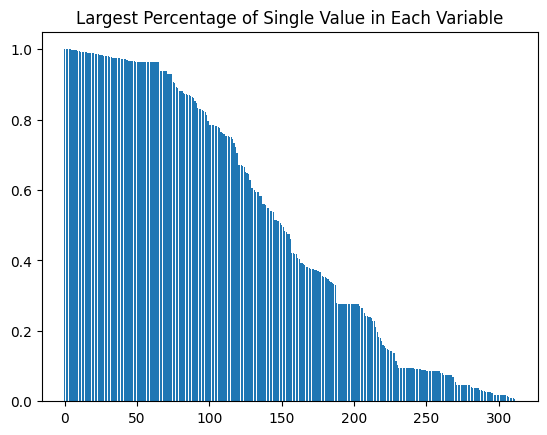

In [22]:
# Find the largest percentage of single value in each variable
records_count = allData.shape[0]
col_most_values,col_large_value = {},{}

for col in allFeatures:
    value_count = allData[col].groupby(allData[col]).count()
    col_most_values[col] = max(value_count)/records_count
    large_value = value_count[value_count== max(value_count)].index[0]  # Storing the Most Frequent Value
    col_large_value[col] = large_value

# Creating a DataFrame to Store and Sort Results
col_most_values_df = pd.DataFrame.from_dict(col_most_values, orient = 'index')
col_most_values_df.columns = ['max percent']
col_most_values_df = col_most_values_df.sort_values(by = 'max percent', ascending = False)

# Visualizing the Results
pcnt = list(col_most_values_df[:500]['max percent'])
vars = list(col_most_values_df[:500].index)
plt.bar(range(len(pcnt)), height = pcnt)
plt.title('Largest Percentage of Single Value in Each Variable')

From the chart above, we notice there are some highly imbalanced features (Left side of the chart). Some variables have a single value occupying nearly 100% of records. These features may not provide useful predictive power and could be removed.

Thus we analyze whether categorical variables where one value dominates more than 90% of the observations (majority value) exhibit significantly different bad sample rates (default rates) between the majority value and minority values.

/var/folders/zc/jpm0y1v14gz9jrsg2p3c9h6c0000gn/T/ipykernel_6013/2227554251.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[col] = temp.apply(lambda x: int(x[col]==large_value),axis=1)  # Encoding Majority vs. Minority Values
/var/folders/zc/jpm0y1v14gz9jrsg2p3c9h6c0000gn/T/ipykernel_6013/2227554251.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[col] = temp.apply(lambda x: int(x[col]==large_value),axis=1)  # Encoding Majority vs. Minority Values
/var/folders/zc/jpm0y1v14gz9jrsg2p3c9h6c0000

<BarContainer object of 77 artists>

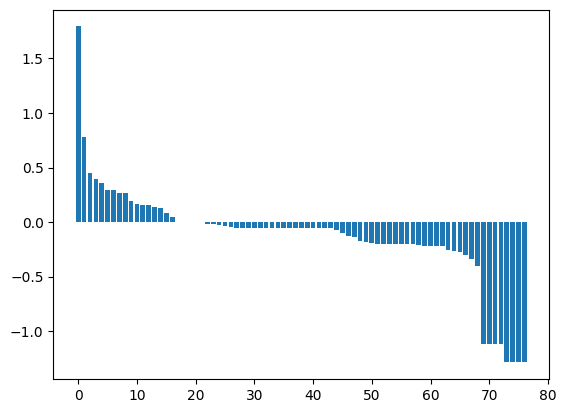

In [ ]:
# Identifying Highly Imbalanced Features
large_percent_cols = list(col_most_values_df[col_most_values_df['max percent']>=0.9].index)

# Calculating Bad Sample Rate Difference
bad_rate_diff = {}
for col in large_percent_cols:
    large_value = col_large_value[col]
    temp = allData[[col,'target']]
    temp[col] = temp.apply(lambda x: int(x[col]==large_value),axis=1)  # Encoding Majority vs. Minority Values
    bad_rate = temp.groupby(col).mean()   # Computing Default Rates
    if bad_rate.iloc[0]['target'] == 0:   # Calculating Bad Rate Log Difference
        bad_rate_diff[col] = 0
        continue
    bad_rate_diff[col] = np.log(bad_rate.iloc[0]['target']/bad_rate.iloc[1]['target'])

# Sort and Visualize the Results
bad_rate_diff_sorted = sorted(bad_rate_diff.items(),key=lambda x: x[1], reverse=True)
bad_rate_diff_sorted_values = [x[1] for x in bad_rate_diff_sorted]
plt.bar(x = range(len(bad_rate_diff_sorted_values)), height = bad_rate_diff_sorted_values)

In [24]:
# Removing Features with Insignificant Bad Sample Rate Differences
for col in large_percent_cols:
    if col in numerical_var:
        numerical_var.remove(col)
    else:
        categorical_var.remove(col)
    del allData[col]

In [25]:
# Remove categorical features with > 80% missing values
missing_pcnt_threshould_1 = 0.8
for col in categorical_var:
    missingRate = MissingCategorial(allData,col)
    print('{0} has missing rate as {1}'.format(col,missingRate))
    if missingRate > missing_pcnt_threshould_1:
        categorical_var.remove(col)
        del allData[col]
allData_bk = allData.copy()

UserInfo_1 has missing rate as 0.00019047619047619048
UserInfo_3 has missing rate as 0.0002380952380952381
WeblogInfo_2 has missing rate as 0.05333333333333334
UserInfo_5 has missing rate as 0.0
UserInfo_6 has missing rate as 0.0
UserInfo_7 has missing rate as 0.0
UserInfo_9 has missing rate as 0.0
UserInfo_10 has missing rate as 0.0
UserInfo_11 has missing rate as 0.6282380952380953
UserInfo_12 has missing rate as 0.6282380952380953
UserInfo_13 has missing rate as 0.6282380952380953
UserInfo_14 has missing rate as 0.0
UserInfo_15 has missing rate as 0.0
UserInfo_16 has missing rate as 0.0
UserInfo_17 has missing rate as 0.0
UserInfo_19 has missing rate as 0.0
WeblogInfo_19 has missing rate as 0.0960952380952381
WeblogInfo_20 has missing rate as 0.26466666666666666
WeblogInfo_21 has missing rate as 0.09995238095238096
WeblogInfo_30 has missing rate as 0.008380952380952381
SocialNetwork_12 has missing rate as 0.0
SocialNetwork_13 has missing rate as 0.0
SocialNetwork_17 has missing rate

In [26]:
# Encode categorical variables using onehot encoder
dummy_map = {}
dummy_columns = []
for raw_col in categorical_var:
    dummies = pd.get_dummies(allData.loc[:, raw_col], prefix=raw_col)
    col_onehot = pd.concat([allData[raw_col], dummies], axis=1)
    col_onehot = col_onehot.drop_duplicates()
    allData = pd.concat([allData, dummies], axis=1)
    del allData[raw_col]
    dummy_map[raw_col] = col_onehot
    dummy_columns = dummy_columns + list(dummies)

with open('dummy_map.pkl',"wb") as f:
    f.write(pickle.dumps(dummy_map))

with open('dummy_columns.pkl',"wb") as f:
    f.write(pickle.dumps(dummy_columns))

#### Numerical Variables

In [27]:
# Remove numerical features with > 80% missing values
missing_pcnt_threshould_2 = 0.8
deleted_var = []
for col in numerical_var:
    missingRate = MissingContinuous(allData, col)
    print('{0} has missing rate as {1}'.format(col, missingRate))
    if missingRate > missing_pcnt_threshould_2:
        deleted_var.append(col)
        print('we delete variable {} because of its high missing rate'.format(col))
    else:
        if missingRate > 0:
            not_missing = allData.loc[allData[col] == allData[col]][col]
            #makeuped = allData[col].map(lambda x: MakeupRandom(x, list(not_missing)))
            missing_position = allData.loc[allData[col] != allData[col]][col].index
            not_missing_sample = random.sample(list(not_missing), len(missing_position))
            allData.loc[missing_position,col] = not_missing_sample
            #del allData[col]
            #allData[col] = makeuped
            missingRate2 = MissingContinuous(allData, col)
            print('missing rate after making up is:{}'.format(str(missingRate2)))

if deleted_var != []:
    for col in deleted_var:
        numerical_var.remove(col)
        del allData[col]

WeblogInfo_1 has missing rate as 0.9678571428571429
we delete variable WeblogInfo_1 because of its high missing rate
WeblogInfo_3 has missing rate as 0.9678571428571429
we delete variable WeblogInfo_3 because of its high missing rate
WeblogInfo_4 has missing rate as 0.053285714285714283
missing rate after making up is:0.0
WeblogInfo_5 has missing rate as 0.053285714285714283
missing rate after making up is:0.0
WeblogInfo_6 has missing rate as 0.053285714285714283
missing rate after making up is:0.0
WeblogInfo_7 has missing rate as 0.0
WeblogInfo_8 has missing rate as 0.0
WeblogInfo_15 has missing rate as 0.0
WeblogInfo_16 has missing rate as 0.0
WeblogInfo_17 has missing rate as 0.0
WeblogInfo_18 has missing rate as 0.0
UserInfo_18 has missing rate as 0.0
WeblogInfo_24 has missing rate as 0.008380952380952381
missing rate after making up is:0.0
WeblogInfo_27 has missing rate as 0.008380952380952381
missing rate after making up is:0.0
WeblogInfo_33 has missing rate as 0.0083809523809523

In [28]:
# Standardize numerical variables
max_min_standardized = {}
for col in numerical_var:
    truncation = Outlier_Dectection(allData, col)
    upper, lower = max(truncation), min(truncation)
    d = upper - lower
    if d == 0:
        print("{} is almost a constant".format(col))
        numerical_var.remove(col)
        continue
    allData[col] = truncation.map(lambda x: (upper - x)/d)
    max_min_standardized[col] = [lower, upper]

with open('max_min_standardized.pkl',"wb") as f:
    f.write(pickle.dumps(max_min_standardized))

allData.to_csv('allData_1_DNN.csv', header=True,encoding='gbk', columns = allData.columns, index=False)
allData = pd.read_csv('allData_1_DNN.csv', header=0,encoding='gbk')

WeblogInfo_8 is almost a constant
WeblogInfo_24 is almost a constant
WeblogInfo_33 is almost a constant
SocialNetwork_8 is almost a constant
SocialNetwork_10 is almost a constant
UserupdateInfo_30_IDNUMBER is almost a constant
UserupdateInfo_30_MARRIAGESTATUSID is almost a constant
UserupdateInfo_60_IDNUMBER is almost a constant
UserupdateInfo_60_MARRIAGESTATUSID is almost a constant
UserupdateInfo_90_IDNUMBER is almost a constant
UserupdateInfo_90_MARRIAGESTATUSID is almost a constant
UserupdateInfo_120_IDNUMBER is almost a constant
UserupdateInfo_120_MARRIAGESTATUSID is almost a constant
UserupdateInfo_150_IDNUMBER is almost a constant
UserupdateInfo_150_MARRIAGESTATUSID is almost a constant
UserupdateInfo_180_IDNUMBER is almost a constant
UserupdateInfo_180_MARRIAGESTATUSID is almost a constant


### **Stage 3. Construct XGBoost model for the Credit Prediction**
#### Step 1: Loading the data and data preprocessing

In [40]:
# Load allData_1_DNN.csv
allData = pd.read_csv('allData_1_DNN.csv', header=0,encoding='gbk')
all_features = list(allData.columns)
all_features.remove('target')

# Set X_train and y_train
all_features.remove('ListingInfo')
X_train, y_train = allData[all_features], allData['target']
X_train.head()

,Idx,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,WeblogInfo_15,WeblogInfo_16,WeblogInfo_17,WeblogInfo_18,...,SocialNetwork_12_-1,SocialNetwork_12_0,SocialNetwork_12_1,SocialNetwork_13_0,SocialNetwork_13_1,SocialNetwork_13_2,SocialNetwork_17_0,SocialNetwork_17_1,SocialNetwork_17_2,SocialNetwork_17_3
0,7761,1.0,1.0,1.0,1.000000,0,0,1.000000,1.0000,1.0,...,False,True,False,True,False,False,False,True,False,False
1,59034,1.0,1.0,1.0,0.152542,2,0,0.000000,0.2500,0.2,...,True,False,False,True,False,False,True,False,False,False
2,42875,1.0,1.0,1.0,0.932203,0,0,1.000000,1.0000,0.6,...,True,False,False,True,False,False,True,False,False,False
3,30952,0.2,1.0,0.2,0.593220,0,1,0.333333,0.6875,0.8,...,True,False,False,True,False,False,True,False,False,False
4,72664,0.4,0.6,0.4,0.050847,1,0,0.000000,0.0000,0.6,...,True,False,False,True,False,False,True,False,False,False


In [41]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

#### Step 2: Tuning the hyperparamters 
We use GridSearchCV and 5 fold cross-validation（cv=5）. ROC AUC（scoring='roc_auc'）is set to evaluate the model.

In [ ]:
# max_depth, min_child_weight
param_test1 = {'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)}
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=100, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test1, scoring='roc_auc', n_jobs=4, cv=5)
gsearch1.fit(X_train, y_train)
best_max_depth, best_min_child_weight = gsearch1.best_params_['max_depth'], gsearch1.best_params_['min_child_weight'] 

# gamma
param_test2 = {'gamma': [i / 10.0 for i in range(0, 5)]}
gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=100, subsample=0.8, colsample_bytree=0.8, max_depth=best_max_depth,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test2, scoring='roc_auc', n_jobs=4, cv=5)
gsearch2.fit(X_train, y_train)
best_gamma = gsearch2.best_params_['gamma'] 

# subsample, colsample_bytree
param_test3 = {'subsample': [i / 10.0 for i in range(6, 10)], 'colsample_bytree': [i / 10.0 for i in range(6, 10)]}
gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=best_max_depth, gamma=best_gamma,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test3, scoring='roc_auc', n_jobs=4, cv=5)
gsearch3.fit(X_train, y_train)
best_colsample_bytree, best_subsample = gsearch3.best_params_['colsample_bytree'], gsearch3.best_params_['subsample']  

# reg_alpha（L1 regularization）
param_test4 = {'reg_alpha': [0.01, 0.1, 1, 10, 50, 100, 200, 500]}
gsearch4 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=best_max_depth, gamma=best_gamma,
                                                colsample_bytree=best_colsample_bytree, subsample=best_subsample,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test4, scoring='roc_auc', n_jobs=4, cv=5)
gsearch4.fit(X_train, y_train)
best_reg_alpha = gsearch4.best_params_['reg_alpha']  # 50

# n_estimators
param_test5 = {'n_estimators': range(100, 401, 10)}
gsearch5 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, max_depth=best_max_depth, gamma=best_gamma,
                                                colsample_bytree=best_colsample_bytree, subsample=best_subsample, reg_alpha=best_reg_alpha,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test5, scoring='roc_auc', n_jobs=4, cv=5)
gsearch5.fit(X_train, y_train)
best_n_estimators = gsearch5.best_params_  # 390

/Users/yangbohao/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/yangbohao/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [44]:
print('best_max_depth is', best_max_depth,'\n')
print('best_min_child_weight is', best_min_child_weight,'\n')
print('best_gamma is', best_gamma,'\n')
print('best_colsample_bytree is', best_colsample_bytree, '\n')
print('best_subsample is', best_subsample,'\n')
print('best_reg_alpha is', best_reg_alpha,'\n')
print('best_n_estimators is', best_n_estimators,'\n')

best_max_depth is 3 

best_min_child_weight is 1 

best_gamma is 0.4 

best_colsample_bytree is 0.9 

best_subsample is 0.6 

best_reg_alpha is 0.01 

best_n_estimators is {'n_estimators': 150} 



#### Step 3: Train the best model

In [46]:
# Train the model
best_xgb = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth= best_max_depth, gamma=best_gamma,
                         colsample_bytree = best_colsample_bytree, subsample = best_subsample, reg_alpha=best_reg_alpha,
                         min_child_weight=best_min_child_weight, objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
best_xgb.fit(X_train,y_train)
y_pred = best_xgb.predict_proba(X_train)[:,1]
print('roc_auc:', roc_auc_score(y_train, y_pred)) 

roc_auc: 0.8422086354451496


The roc_auc is 0.84, meaning that our model is quite accurate.

#### Step 4: Feature Selection

In [48]:
# Check the deature importance
feature_importance = best_xgb.feature_importances_
print(feature_importance)

[0.00687468 0.00888889 0.004371   0.00954111 0.         0.00475323
 0.00677163 0.00357031 0.00602287 0.00405412 0.0053305  0.
 0.00398123 0.         0.         0.00490083 0.00442172 0.00367729
 0.00731777 0.0019913  0.0111595  0.00445888 0.00554421 0.00518562
 0.00771303 0.00527687 0.00471168 0.00456666 0.00430917 0.00548121
 0.00820185 0.00260581 0.00225461 0.00363363 0.00606398 0.00697384
 0.00485196 0.01319509 0.00516538 0.00647991 0.00386265 0.00741782
 0.00514482 0.00502619 0.0048009  0.00332975 0.00591459 0.00453492
 0.         0.00615196 0.00868111 0.00550454 0.00349147 0.00563853
 0.00518411 0.         0.00737805 0.00476384 0.00624486 0.00545405
 0.00575675 0.00535834 0.00260312 0.00646673 0.00129723 0.00258653
 0.00708364 0.00586329 0.00569114 0.00350338 0.00515204 0.00822747
 0.         0.00477516 0.0060203  0.         0.00493921 0.00728327
 0.0045275  0.00506521 0.00597944 0.00547261 0.00501468 0.01211145
 0.00768776 0.00498228 0.00457698 0.00702003 0.         0.
 0.00354194

In [ ]:
# Filter out some uninformative variables using feature importance
X_train_temp = X_train.copy()
features_in_model = all_features

# set the condition as min(feature_importance)<0.00001
while(min(feature_importance)<0.00001):
    features_in_model = [features_in_model[i] for i in range(len(feature_importance)) if feature_importance[i] > 0.00001]
    X_train_temp= X_train_temp[features_in_model]
    best_xgb.fit(X_train_temp, y_train)
    feature_importance = best_xgb.feature_importances_

# Calculate AUC
y_pred = best_xgb.predict_proba(X_train_temp)[:,1]
print('roc_aus:', roc_auc_score(y_train, y_pred))
print('There are {} features in the raw data'.format(X_train.shape[1]))  
print('There are {} features in the reduced data'.format(X_train_temp.shape[1])) 

0.8418256916026273
There are 402 features in the raw data
There are 128 features in the reduced data


The AUC is approximately 0.84, which is similar as before, meaning that our dimensional reduction is effctive. We reduce our features from 402 to 128, improving our model.